# Neural Network Model Training with Ablation Study
## GoBest Cab - Dangerous Driving Behaviour Detection

This notebook implements a Neural Network (MLP) classifier for detecting dangerous driving behaviour with:
- MLflow experiment tracking
- Class imbalance handling
- Regularization techniques to prevent overfitting
- Comprehensive ablation study

In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    f1_score, precision_score, recall_score, accuracy_score,
    roc_auc_score, confusion_matrix, classification_report,
    ConfusionMatrixDisplay, roc_curve, precision_recall_curve
)
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. MLflow Setup

In [2]:
# MLflow Configuration
# Set tracking URI to the MLflow server
mlflow.set_tracking_uri("http://localhost:5000")

# Define experiment naming convention: {model_name}_{dataset}_{reg/noreg}
EXPERIMENT_BASE_NAME = "NeuralNetwork_balanced_smote"

print(f"MLflow Tracking URI: {mlflow.get_tracking_uri()}")

MLflow Tracking URI: http://localhost:5000


## 2. Load Data

In [3]:
# Load the main dataset
DATA_PATH = "../../Datasets/ca2_balanced_smote/balanced_smote.csv"
CLASS_WEIGHTS_PATH = "../../Datasets/ca2_balanced_smote/class_weights.json"

df = pd.read_csv(DATA_PATH)

# Load class weights from JSON
with open(CLASS_WEIGHTS_PATH, 'r') as f:
    class_weights_info = json.load(f)

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['label'].value_counts())
print(f"\nClass weights info:")
print(json.dumps(class_weights_info, indent=2))

Dataset shape: (29988, 144)

Class distribution:
label
0    14994
1    14994
Name: count, dtype: int64

Class weights info:
{
  "class_0_weight": 0.665999733226624,
  "class_1_weight": 2.0060265166733626,
  "scale_pos_weight": 3.0120530333467253,
  "original_class_0": 14994,
  "original_class_1": 4978,
  "imbalance_ratio": 3.0120530333467257
}


In [4]:
# Prepare features and target
# IMPORTANT: Exclude bookingID and is_dangerous_trip - they are just references
columns_to_drop = ['bookingID', 'label']

# Check if is_dangerous_trip exists and drop it
if 'is_dangerous_trip' in df.columns:
    columns_to_drop.append('is_dangerous_trip')

# Also drop is_synthetic if it exists (it's a SMOTE indicator, not a feature)
if 'is_synthetic' in df.columns:
    columns_to_drop.append('is_synthetic')

X = df.drop(columns=columns_to_drop)
y = df['label']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
print(X.columns.tolist()[:10], "... and", len(X.columns)-10, "more")

Features shape: (29988, 141)
Target shape: (29988,)

Feature columns (141):
['vehicle_key', 'trip_duration_sec', 'total_distance_km', 'avg_gps_accuracy', 'harsh_acceleration_count', 'harsh_braking_count', 'sharp_turn_count', 'speeding_event_count', 'phone_distraction_count', 'avg_acceleration_magnitude'] ... and 131 more


## 3. Data Preprocessing

In [5]:
# Check for missing values and handle them
print("Missing values per column:")
missing = X.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median (robust to outliers)
    X = X.fillna(X.median())
    print("\nMissing values filled with median.")
else:
    print("No missing values found.")

# Check for infinite values
inf_count = np.isinf(X.select_dtypes(include=[np.number])).sum().sum()
print(f"\nInfinite values count: {inf_count}")
if inf_count > 0:
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.median())
    print("Infinite values replaced with median.")

Missing values per column:
No missing values found.

Infinite values count: 0


In [6]:
# Train-test split with stratification to preserve class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining class distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nTest class distribution:")
print(y_test.value_counts(normalize=True))

Training set: 23990 samples
Test set: 5998 samples

Training class distribution:
label
1    0.5
0    0.5
Name: proportion, dtype: float64

Test class distribution:
label
0    0.5
1    0.5
Name: proportion, dtype: float64


In [7]:
# Feature scaling using StandardScaler (CRITICAL for Neural Networks!)
# Neural networks are very sensitive to feature scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), 
    columns=X_train.columns, 
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), 
    columns=X_test.columns, 
    index=X_test.index
)

print("Feature scaling completed using StandardScaler.")
print(f"Scaled feature means range: [{X_train_scaled.mean().min():.4f}, {X_train_scaled.mean().max():.4f}]")
print(f"Scaled feature stds range: [{X_train_scaled.std().min():.4f}, {X_train_scaled.std().max():.4f}]")

Feature scaling completed using StandardScaler.
Scaled feature means range: [-0.0000, 0.0000]
Scaled feature stds range: [1.0000, 1.0000]


## 4. Class Imbalance Handling

In [8]:
# Compute sample weights based on class distribution
# Note: sklearn's MLPClassifier doesn't support class_weight, but we can use sample weights
class_weight_dict = {
    0: class_weights_info.get('class_0_weight', 1.0),
    1: class_weights_info.get('class_1_weight', 3.0)
}

print(f"Class weight dictionary: {class_weight_dict}")
print("\nNote: sklearn MLPClassifier doesn't directly support class weights.")
print("Using SMOTE-balanced dataset for class balance.")

Class weight dictionary: {0: 0.665999733226624, 1: 2.0060265166733626}

Note: sklearn MLPClassifier doesn't directly support class weights.
Using SMOTE-balanced dataset for class balance.


## 5. Helper Functions

In [9]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name="Model"):
    """
    Comprehensive model evaluation with all required metrics.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, y_train_pred),
        'test_accuracy': accuracy_score(y_test, y_test_pred),
        'train_f1': f1_score(y_train, y_train_pred),
        'test_f1': f1_score(y_test, y_test_pred),
        'precision': precision_score(y_test, y_test_pred),
        'recall': recall_score(y_test, y_test_pred),
        'roc_auc': roc_auc_score(y_test, y_test_proba),
    }
    
    # Detect overfitting
    overfit_gap = metrics['train_f1'] - metrics['test_f1']
    metrics['overfit_gap'] = overfit_gap
    metrics['is_overfitting'] = overfit_gap > 0.05  # 5% gap threshold
    
    # Print results
    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"\nAccuracy  - Train: {metrics['train_accuracy']:.4f} | Test: {metrics['test_accuracy']:.4f}")
    print(f"F1 Score  - Train: {metrics['train_f1']:.4f} | Test: {metrics['test_f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall:    {metrics['recall']:.4f}")
    print(f"ROC-AUC:   {metrics['roc_auc']:.4f}")
    print(f"\nOverfit Gap (Train F1 - Test F1): {overfit_gap:.4f}")
    if metrics['is_overfitting']:
        print("⚠️  WARNING: Model shows signs of overfitting!")
    else:
        print("✅ Model generalization looks good.")
    
    return metrics, y_test_pred, y_test_proba


def plot_confusion_matrix(y_test, y_pred, model_name="Model"):
    """
    Plot confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe (0)', 'Dangerous (1)'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    return fig


def plot_roc_curve(y_test, y_proba, model_name="Model"):
    """
    Plot ROC curve.
    """
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    plt.tight_layout()
    return fig


def plot_loss_curve(model, model_name="Model"):
    """
    Plot training loss curve.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(model.loss_curve_, 'b-', linewidth=2)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Loss')
    ax.set_title(f'{model_name} - Training Loss Curve')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig

## 6. Cross-Validation Setup

In [10]:
# Stratified K-Fold Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def perform_cross_validation(model, X, y, cv=cv):
    """
    Perform cross-validation and return scores.
    """
    scoring = ['f1', 'precision', 'recall', 'roc_auc', 'accuracy']
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    
    print("\nCross-Validation Results (5-fold):")
    print("-" * 50)
    for metric in scoring:
        train_scores = cv_results[f'train_{metric}']
        test_scores = cv_results[f'test_{metric}']
        print(f"{metric.upper():12} - Train: {train_scores.mean():.4f} (+/- {train_scores.std()*2:.4f}) | "
              f"Test: {test_scores.mean():.4f} (+/- {test_scores.std()*2:.4f})")
    
    return cv_results

---
## 7. Model Training WITHOUT Regularization
### Baseline Neural Network Model (High Complexity, No Regularization)

In [11]:
# Set experiment for no regularization
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_noreg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_noreg")

Experiment: NeuralNetwork_balanced_smote_noreg


In [12]:
# Neural Network WITHOUT Regularization (baseline - likely to overfit)
nn_noreg = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # Reduced for faster training
    activation='relu',
    solver='adam',
    alpha=0.0001,  # Very weak L2 regularization (default)
    batch_size='auto',
    learning_rate='constant',
    learning_rate_init=0.001,
    max_iter=200,  # Reduced for faster training
    shuffle=True,
    random_state=42,
    tol=1e-4,
    verbose=False,
    early_stopping=False,  # No early stopping
    n_iter_no_change=10
)

print("Neural Network Model (No Regularization) Configuration:")
print(f"Architecture: Input -> 128 -> 64 -> Output")
print(f"Total hidden layers: 2")
print(f"Activation: ReLU")
print(f"L2 penalty (alpha): {nn_noreg.alpha}")
print(nn_noreg.get_params())

Neural Network Model (No Regularization) Configuration:
Architecture: Input -> 128 -> 64 -> Output
Total hidden layers: 2
Activation: ReLU
L2 penalty (alpha): 0.0001
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (128, 64), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 200, 'momentum': 0.9, 'n_iter_no_change': 10, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': False, 'warm_start': False}


Training Neural Network without regularization...

Converged in 178 iterations

Neural Network (No Regularization) Evaluation Results

Accuracy  - Train: 1.0000 | Test: 0.8288
F1 Score  - Train: 1.0000 | Test: 0.8363
Precision: 0.8012
Recall:    0.8746
ROC-AUC:   0.8935

Overfit Gap (Train F1 - Test F1): 0.1637
⚠️  WARNING: Model shows signs of overfitting!


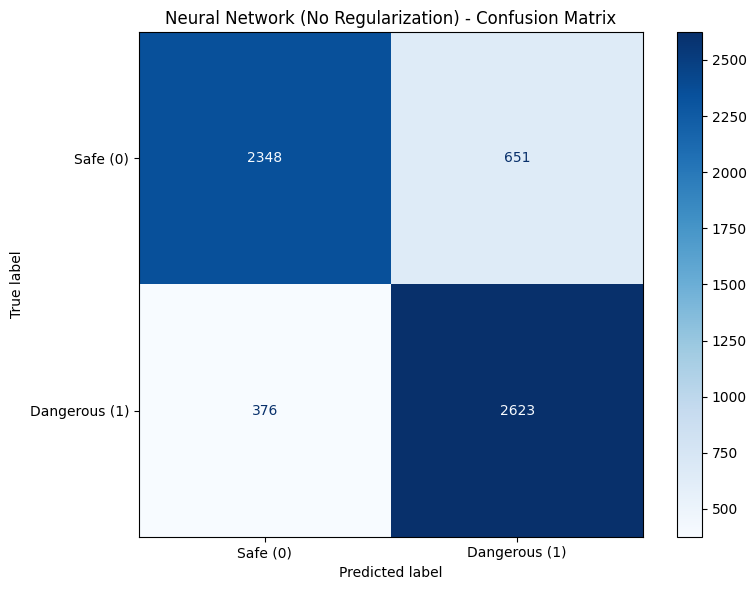

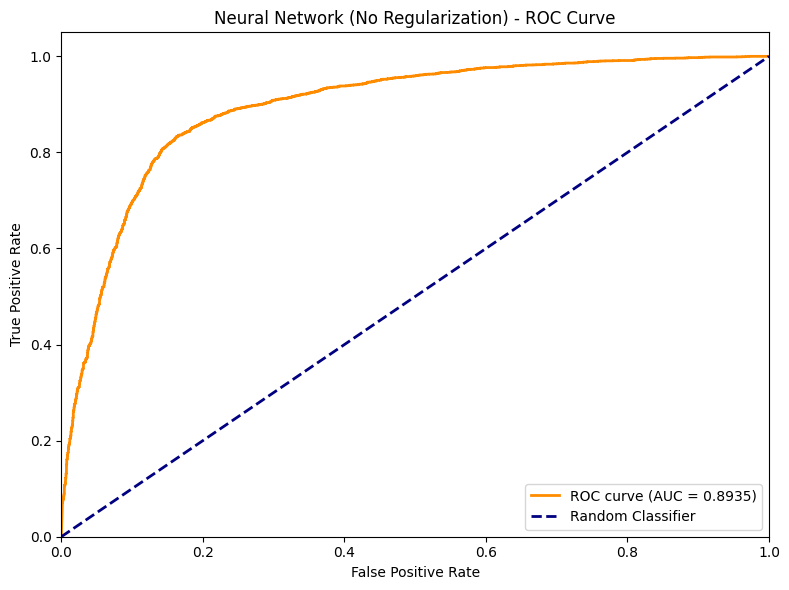

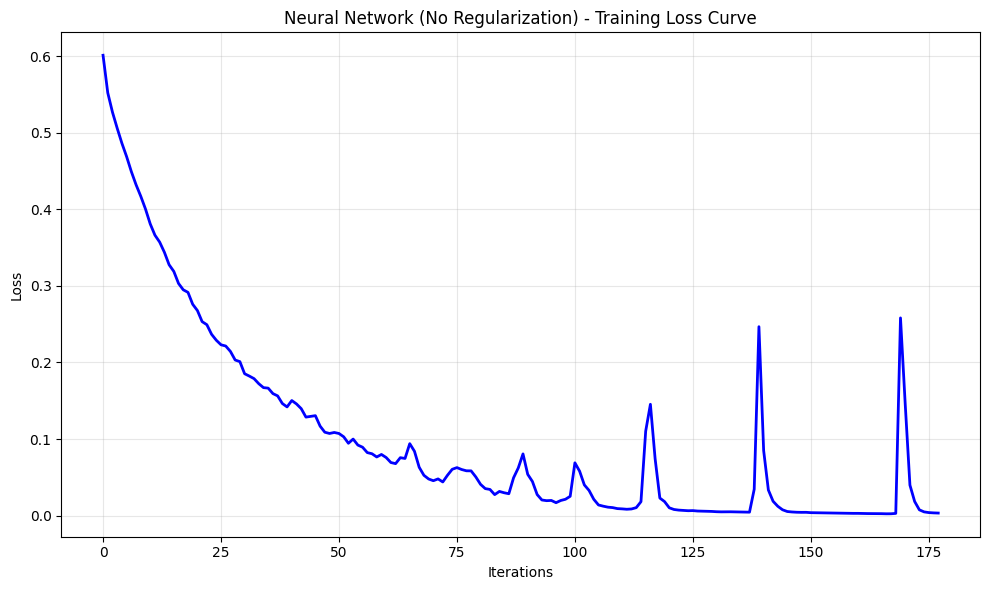

2026/01/31 17:38:52 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: 6282a82439194bb3a87f7523dc6f8af7
🏃 View run NeuralNetwork_NoReg_Baseline at: http://localhost:5000/#/experiments/7/runs/6282a82439194bb3a87f7523dc6f8af7
🧪 View experiment at: http://localhost:5000/#/experiments/7


In [13]:
# Train the model without regularization
with mlflow.start_run(run_name="NeuralNetwork_NoReg_Baseline"):
    # Log parameters
    params = nn_noreg.get_params()
    # Convert tuple to string for MLflow
    params['hidden_layer_sizes'] = str(params['hidden_layer_sizes'])
    mlflow.log_params(params)
    mlflow.log_param("regularization", "none")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model
    print("Training Neural Network without regularization...")
    nn_noreg.fit(X_train_scaled, y_train)
    
    print(f"\nConverged in {nn_noreg.n_iter_} iterations")
    
    # Evaluate
    metrics_noreg, y_pred_noreg, y_proba_noreg = evaluate_model(
        nn_noreg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Neural Network (No Regularization)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_noreg['train_accuracy'],
        'test_accuracy': metrics_noreg['test_accuracy'],
        'train_f1': metrics_noreg['train_f1'],
        'test_f1': metrics_noreg['test_f1'],
        'precision': metrics_noreg['precision'],
        'recall': metrics_noreg['recall'],
        'roc_auc': metrics_noreg['roc_auc'],
        'overfit_gap': metrics_noreg['overfit_gap'],
        'n_iterations': nn_noreg.n_iter_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_noreg, "Neural Network (No Regularization)")
    mlflow.log_figure(fig_cm, "confusion_matrix_noreg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_noreg, "Neural Network (No Regularization)")
    mlflow.log_figure(fig_roc, "roc_curve_noreg.png")
    plt.show()
    
    # Plot and log loss curve
    fig_loss = plot_loss_curve(nn_noreg, "Neural Network (No Regularization)")
    mlflow.log_figure(fig_loss, "loss_curve_noreg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(nn_noreg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [14]:
# Cross-validation for no-reg model (Note: Can be slow for neural networks)
print("\n" + "="*60)
print("Cross-Validation for Neural Network (No Regularization)")
print("="*60)
print("Note: This may take a few minutes...")
cv_results_noreg = perform_cross_validation(nn_noreg, X_train_scaled, y_train)


Cross-Validation for Neural Network (No Regularization)
Note: This may take a few minutes...

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 1.0000 (+/- 0.0000) | Test: 0.8167 (+/- 0.0074)
PRECISION    - Train: 1.0000 (+/- 0.0000) | Test: 0.7830 (+/- 0.0096)
RECALL       - Train: 1.0000 (+/- 0.0000) | Test: 0.8533 (+/- 0.0052)
ROC_AUC      - Train: 1.0000 (+/- 0.0000) | Test: 0.8773 (+/- 0.0040)
ACCURACY     - Train: 1.0000 (+/- 0.0000) | Test: 0.8084 (+/- 0.0084)


In [15]:
# Classification Report
print("\nClassification Report (No Regularization):")
print(classification_report(y_test, y_pred_noreg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (No Regularization):
               precision    recall  f1-score   support

     Safe (0)       0.86      0.78      0.82      2999
Dangerous (1)       0.80      0.87      0.84      2999

     accuracy                           0.83      5998
    macro avg       0.83      0.83      0.83      5998
 weighted avg       0.83      0.83      0.83      5998



---
## 8. Model Training WITH Regularization
### Neural Network with Regularization to Combat Overfitting

In [16]:
# Set experiment for regularized model
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_reg")

print(f"Experiment: {EXPERIMENT_BASE_NAME}_reg")

Experiment: NeuralNetwork_balanced_smote_reg


In [17]:
# Neural Network WITH Regularization
nn_reg = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),  # Smaller network
    activation='relu',
    solver='adam',
    alpha=0.01,  # Strong L2 regularization (weight decay)
    batch_size=64,  # Explicit batch size
    learning_rate='adaptive',  # Adaptive learning rate
    learning_rate_init=0.001,
    max_iter=500,
    shuffle=True,
    random_state=42,
    tol=1e-4,
    verbose=False,
    early_stopping=True,  # Early stopping
    validation_fraction=0.1,
    n_iter_no_change=20
)

print("Neural Network Model (With Regularization) Configuration:")
print("\nRegularization techniques applied:")
print("- Smaller network: (256,128,64) -> (128,64,32)")
print("- Strong L2 regularization (alpha): 0.0001 -> 0.01")
print("- Adaptive learning rate")
print("- Early stopping enabled")
print(f"\nArchitecture: Input -> 128 -> 64 -> 32 -> Output")

Neural Network Model (With Regularization) Configuration:

Regularization techniques applied:
- Smaller network: (256,128,64) -> (128,64,32)
- Strong L2 regularization (alpha): 0.0001 -> 0.01
- Adaptive learning rate
- Early stopping enabled

Architecture: Input -> 128 -> 64 -> 32 -> Output


Training Neural Network with regularization...

Converged in 52 iterations
Best validation score: 0.8120

Neural Network (Regularized) Evaluation Results

Accuracy  - Train: 0.9541 | Test: 0.8059
F1 Score  - Train: 0.9544 | Test: 0.8148
Precision: 0.7791
Recall:    0.8540
ROC-AUC:   0.8794

Overfit Gap (Train F1 - Test F1): 0.1395
⚠️  WARNING: Model shows signs of overfitting!


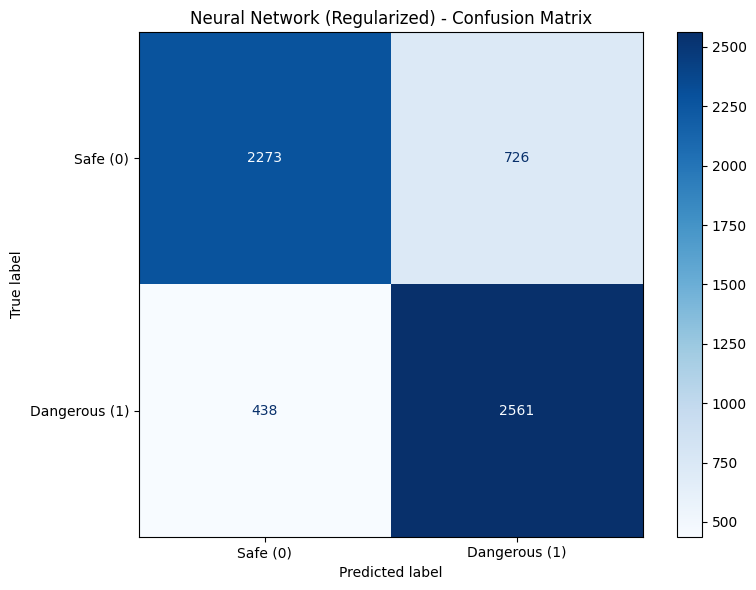

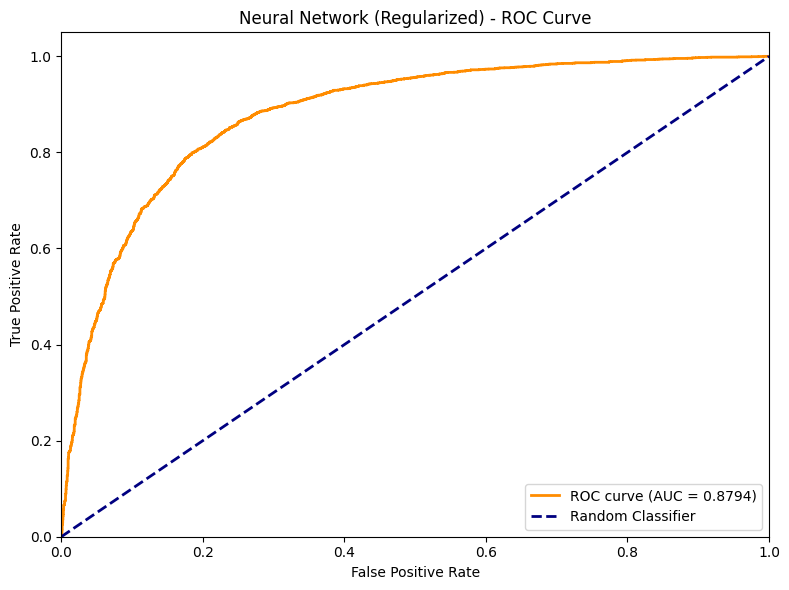

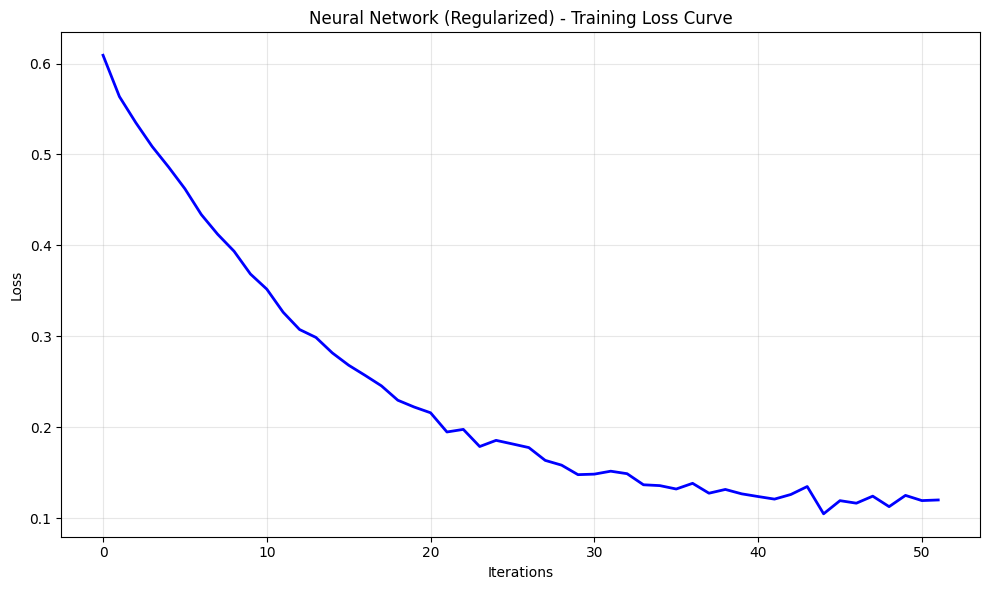

2026/01/31 17:40:16 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: a8b398436564469bbfe902164c5bff76
🏃 View run NeuralNetwork_Regularized at: http://localhost:5000/#/experiments/8/runs/a8b398436564469bbfe902164c5bff76
🧪 View experiment at: http://localhost:5000/#/experiments/8


In [18]:
# Train the model with regularization
with mlflow.start_run(run_name="NeuralNetwork_Regularized"):
    # Log parameters
    params = nn_reg.get_params()
    params['hidden_layer_sizes'] = str(params['hidden_layer_sizes'])
    mlflow.log_params(params)
    mlflow.log_param("regularization", "L2_early_stopping")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("n_features", X_train_scaled.shape[1])
    mlflow.log_param("n_train_samples", X_train_scaled.shape[0])
    
    # Train model
    print("Training Neural Network with regularization...")
    nn_reg.fit(X_train_scaled, y_train)
    
    print(f"\nConverged in {nn_reg.n_iter_} iterations")
    print(f"Best validation score: {nn_reg.best_validation_score_:.4f}")
    
    # Evaluate
    metrics_reg, y_pred_reg, y_proba_reg = evaluate_model(
        nn_reg, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Neural Network (Regularized)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_reg['train_accuracy'],
        'test_accuracy': metrics_reg['test_accuracy'],
        'train_f1': metrics_reg['train_f1'],
        'test_f1': metrics_reg['test_f1'],
        'precision': metrics_reg['precision'],
        'recall': metrics_reg['recall'],
        'roc_auc': metrics_reg['roc_auc'],
        'overfit_gap': metrics_reg['overfit_gap'],
        'n_iterations': nn_reg.n_iter_,
        'best_validation_score': nn_reg.best_validation_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_reg, "Neural Network (Regularized)")
    mlflow.log_figure(fig_cm, "confusion_matrix_reg.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_reg, "Neural Network (Regularized)")
    mlflow.log_figure(fig_roc, "roc_curve_reg.png")
    plt.show()
    
    # Plot and log loss curve
    fig_loss = plot_loss_curve(nn_reg, "Neural Network (Regularized)")
    mlflow.log_figure(fig_loss, "loss_curve_reg.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(nn_reg, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [19]:
# Cross-validation for regularized model
print("\n" + "="*60)
print("Cross-Validation for Neural Network (Regularized)")
print("="*60)
print("Note: This may take a few minutes...")
cv_results_reg = perform_cross_validation(nn_reg, X_train_scaled, y_train)


Cross-Validation for Neural Network (Regularized)
Note: This may take a few minutes...

Cross-Validation Results (5-fold):
--------------------------------------------------
F1           - Train: 0.9584 (+/- 0.0318) | Test: 0.7999 (+/- 0.0220)
PRECISION    - Train: 0.9574 (+/- 0.0438) | Test: 0.7801 (+/- 0.0259)
RECALL       - Train: 0.9594 (+/- 0.0207) | Test: 0.8208 (+/- 0.0273)
ROC_AUC      - Train: 0.9858 (+/- 0.0089) | Test: 0.8671 (+/- 0.0129)
ACCURACY     - Train: 0.9582 (+/- 0.0327) | Test: 0.7946 (+/- 0.0231)


In [20]:
# Classification Report
print("\nClassification Report (Regularized):")
print(classification_report(y_test, y_pred_reg, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Regularized):
               precision    recall  f1-score   support

     Safe (0)       0.84      0.76      0.80      2999
Dangerous (1)       0.78      0.85      0.81      2999

     accuracy                           0.81      5998
    macro avg       0.81      0.81      0.81      5998
 weighted avg       0.81      0.81      0.81      5998



---
## 9. Model Improvement (If F1 Score is Low)
### Enhanced Neural Network with Additional Preprocessing and Tuning

In [21]:
# Check if F1 score needs improvement (target: 0.87-0.90)
# First, determine which model performs better: regularized or non-regularized
f1_target_min = 0.87

print("="*60)
print("MODEL COMPARISON: Regularized vs Non-Regularized")
print("="*60)
print(f"No Regularization - Test F1: {metrics_noreg['test_f1']:.4f} | Overfit Gap: {metrics_noreg['overfit_gap']:.4f}")
print(f"Regularized       - Test F1: {metrics_reg['test_f1']:.4f} | Overfit Gap: {metrics_reg['overfit_gap']:.4f}")

# Select the better model based on Test F1 score
if metrics_noreg['test_f1'] > metrics_reg['test_f1']:
    best_base_model = 'noreg'
    best_base_f1 = metrics_noreg['test_f1']
    best_base_metrics = metrics_noreg
    print(f"\n🏆 Better Model: No Regularization (Test F1: {best_base_f1:.4f})")
else:
    best_base_model = 'reg'
    best_base_f1 = metrics_reg['test_f1']
    best_base_metrics = metrics_reg
    print(f"\n🏆 Better Model: Regularized (Test F1: {best_base_f1:.4f})")

print(f"\nTarget F1 Score Range: {f1_target_min} - 0.90")

if best_base_f1 < f1_target_min:
    print(f"\n⚠️  Best model F1 ({best_base_f1:.4f}) is below target. Applying improvements to {best_base_model} model...")
    NEEDS_IMPROVEMENT = True
else:
    print(f"\n✅ Best model F1 meets target. Model improvement optional.")
    NEEDS_IMPROVEMENT = False

MODEL COMPARISON: Regularized vs Non-Regularized
No Regularization - Test F1: 0.8363 | Overfit Gap: 0.1637
Regularized       - Test F1: 0.8148 | Overfit Gap: 0.1395

🏆 Better Model: No Regularization (Test F1: 0.8363)

Target F1 Score Range: 0.87 - 0.90

⚠️  Best model F1 (0.8363) is below target. Applying improvements to noreg model...


In [22]:
# Enhanced preprocessing: Remove low-variance features
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
variance_selector = VarianceThreshold(threshold=0.01)
X_train_var = variance_selector.fit_transform(X_train_scaled)
X_test_var = variance_selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X_train_scaled.columns[variance_selector.get_support()].tolist()

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Features after variance threshold: {X_train_var.shape[1]}")
print(f"Features removed: {X_train_scaled.shape[1] - X_train_var.shape[1]}")

Original features: 141
Features after variance threshold: 141
Features removed: 0


In [23]:
# Improved Neural Network with optimized hyperparameters
nn_improved = MLPClassifier(
    hidden_layer_sizes=(100, 50),  # Even smaller, simpler network
    activation='tanh',  # Try different activation
    solver='adam',
    alpha=0.05,  # Even stronger L2 regularization
    batch_size=128,  # Larger batch size for stability
    learning_rate='invscaling',  # Decreasing learning rate
    learning_rate_init=0.001,
    power_t=0.5,  # For invscaling
    max_iter=1000,
    shuffle=True,
    random_state=42,
    tol=1e-5,  # Tighter tolerance
    verbose=False,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30  # More patience
)

print("Improved Neural Network Configuration:")
print("- Smaller network: (128,64,32) -> (100,50)")
print("- Changed activation: relu -> tanh")
print("- Stronger L2 regularization (alpha): 0.01 -> 0.05")
print("- Larger batch size: 64 -> 128")
print("- Invscaling learning rate for gradual decrease")
print("- More patience for early stopping: 20 -> 30")
print(f"\nArchitecture: Input -> 100 -> 50 -> Output")

Improved Neural Network Configuration:
- Smaller network: (128,64,32) -> (100,50)
- Changed activation: relu -> tanh
- Stronger L2 regularization (alpha): 0.01 -> 0.05
- Larger batch size: 64 -> 128
- Invscaling learning rate for gradual decrease
- More patience for early stopping: 20 -> 30

Architecture: Input -> 100 -> 50 -> Output


Training improved Neural Network...

Converged in 125 iterations
Best validation score: 0.8036

Neural Network (Improved) Evaluation Results

Accuracy  - Train: 0.9590 | Test: 0.7934
F1 Score  - Train: 0.9589 | Test: 0.7999
Precision: 0.7755
Recall:    0.8259
ROC-AUC:   0.8653

Overfit Gap (Train F1 - Test F1): 0.1590
⚠️  WARNING: Model shows signs of overfitting!


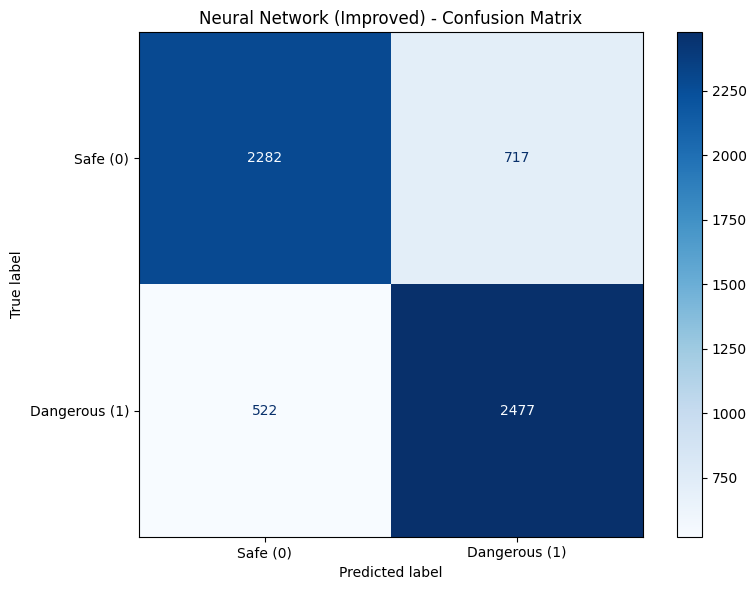

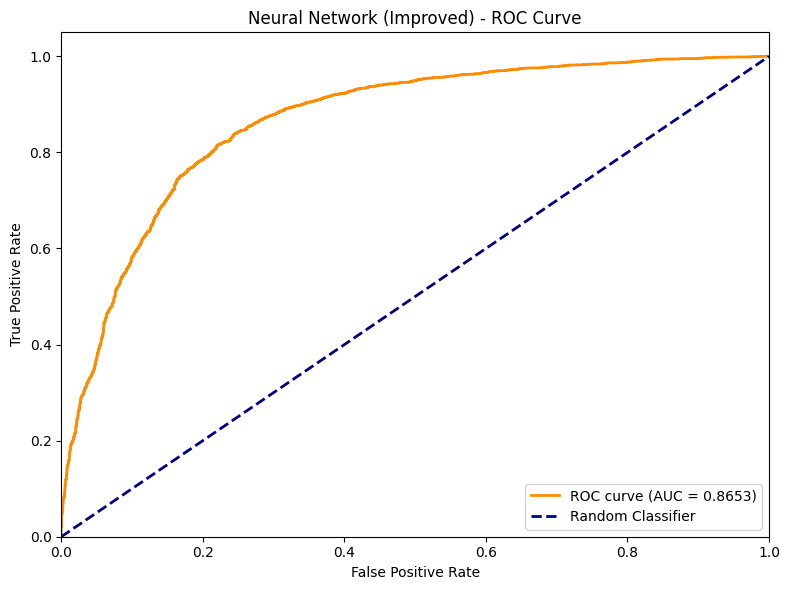

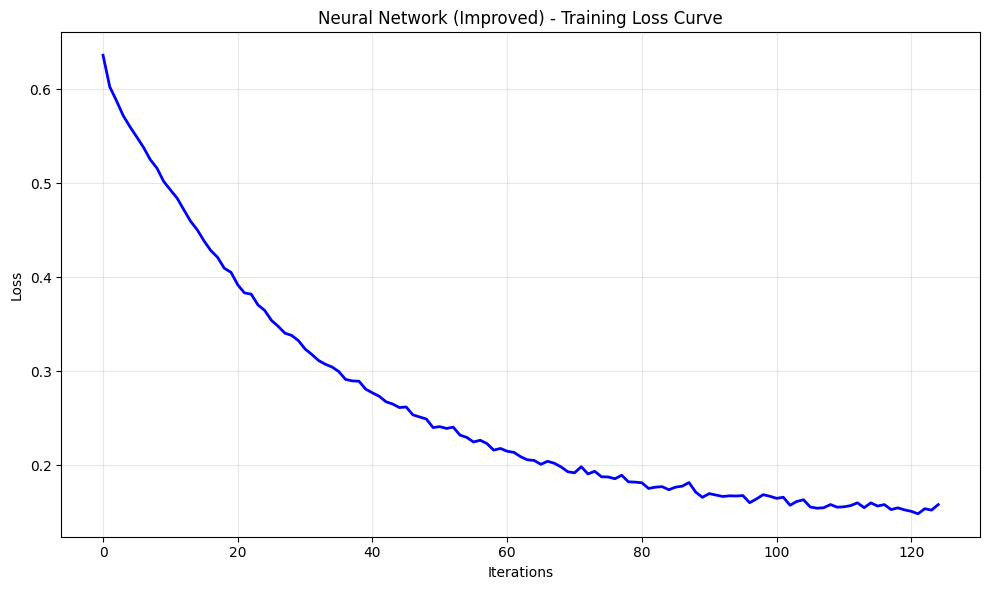

2026/01/31 17:41:22 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Run logged to MLflow with ID: fb5494bca2594eda822856e069fc29ec
🏃 View run NeuralNetwork_Improved at: http://localhost:5000/#/experiments/8/runs/fb5494bca2594eda822856e069fc29ec
🧪 View experiment at: http://localhost:5000/#/experiments/8


In [24]:
# Train improved model
with mlflow.start_run(run_name="NeuralNetwork_Improved"):
    # Log parameters
    params = nn_improved.get_params()
    params['hidden_layer_sizes'] = str(params['hidden_layer_sizes'])
    mlflow.log_params(params)
    mlflow.log_param("regularization", "enhanced")
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("preprocessing", "variance_threshold")
    mlflow.log_param("n_features", X_train_var.shape[1])
    mlflow.log_param("n_train_samples", X_train_var.shape[0])
    
    # Train model
    print("Training improved Neural Network...")
    nn_improved.fit(X_train_var, y_train)
    
    print(f"\nConverged in {nn_improved.n_iter_} iterations")
    print(f"Best validation score: {nn_improved.best_validation_score_:.4f}")
    
    # Evaluate
    metrics_improved, y_pred_improved, y_proba_improved = evaluate_model(
        nn_improved, X_train_var, X_test_var, y_train, y_test, 
        model_name="Neural Network (Improved)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_improved['train_accuracy'],
        'test_accuracy': metrics_improved['test_accuracy'],
        'train_f1': metrics_improved['train_f1'],
        'test_f1': metrics_improved['test_f1'],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'roc_auc': metrics_improved['roc_auc'],
        'overfit_gap': metrics_improved['overfit_gap'],
        'n_iterations': nn_improved.n_iter_,
        'best_validation_score': nn_improved.best_validation_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_improved, "Neural Network (Improved)")
    mlflow.log_figure(fig_cm, "confusion_matrix_improved.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_improved, "Neural Network (Improved)")
    mlflow.log_figure(fig_roc, "roc_curve_improved.png")
    plt.show()
    
    # Plot and log loss curve
    fig_loss = plot_loss_curve(nn_improved, "Neural Network (Improved)")
    mlflow.log_figure(fig_loss, "loss_curve_improved.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_var, y_train)
    mlflow.sklearn.log_model(nn_improved, "model", signature=signature)
    
    print(f"\n✅ Run logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [25]:
# Classification Report for improved model
print("\nClassification Report (Improved):")
print(classification_report(y_test, y_pred_improved, target_names=['Safe (0)', 'Dangerous (1)']))


Classification Report (Improved):
               precision    recall  f1-score   support

     Safe (0)       0.81      0.76      0.79      2999
Dangerous (1)       0.78      0.83      0.80      2999

     accuracy                           0.79      5998
    macro avg       0.79      0.79      0.79      5998
 weighted avg       0.79      0.79      0.79      5998



---
## 10. Model Comparison Summary

In [26]:
# Summary comparison of all models
comparison_df = pd.DataFrame({
    'Model': ['Neural Network (No Reg)', 'Neural Network (Regularized)', 'Neural Network (Improved)'],
    'Train F1': [metrics_noreg['train_f1'], metrics_reg['train_f1'], metrics_improved['train_f1']],
    'Test F1': [metrics_noreg['test_f1'], metrics_reg['test_f1'], metrics_improved['test_f1']],
    'Precision': [metrics_noreg['precision'], metrics_reg['precision'], metrics_improved['precision']],
    'Recall': [metrics_noreg['recall'], metrics_reg['recall'], metrics_improved['recall']],
    'ROC-AUC': [metrics_noreg['roc_auc'], metrics_reg['roc_auc'], metrics_improved['roc_auc']],
    'Overfit Gap': [metrics_noreg['overfit_gap'], metrics_reg['overfit_gap'], metrics_improved['overfit_gap']]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))

# Highlight best model
best_idx = comparison_df['Test F1'].idxmax()
print(f"\n🏆 Best Model by Test F1: {comparison_df.loc[best_idx, 'Model']} (F1: {comparison_df.loc[best_idx, 'Test F1']:.4f})")


MODEL COMPARISON SUMMARY
                       Model  Train F1  Test F1  Precision   Recall  ROC-AUC  Overfit Gap
     Neural Network (No Reg)  1.000000 0.836282   0.801161 0.874625 0.893528     0.163718
Neural Network (Regularized)  0.954351 0.814827   0.779130 0.853951 0.879353     0.139525
   Neural Network (Improved)  0.958927 0.799935   0.775517 0.825942 0.865282     0.158992

🏆 Best Model by Test F1: Neural Network (No Reg) (F1: 0.8363)


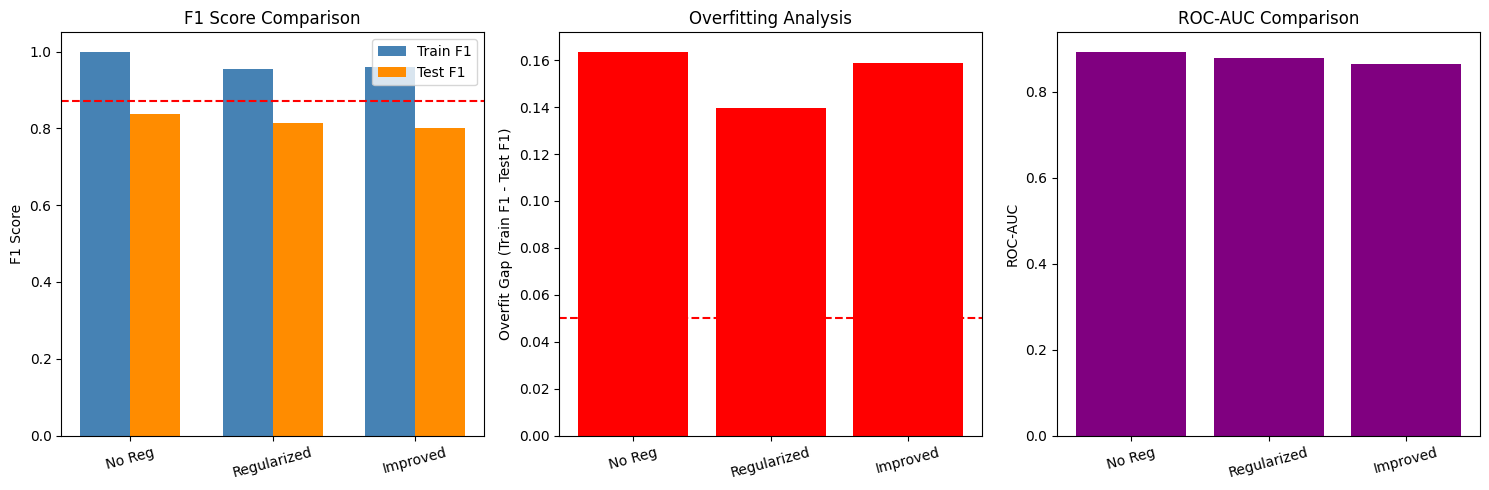

In [27]:
# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score comparison
x = range(len(comparison_df))
width = 0.35
axes[0].bar([i - width/2 for i in x], comparison_df['Train F1'], width, label='Train F1', color='steelblue')
axes[0].bar([i + width/2 for i in x], comparison_df['Test F1'], width, label='Test F1', color='darkorange')
axes[0].set_xticks(x)
axes[0].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[0].set_ylabel('F1 Score')
axes[0].set_title('F1 Score Comparison')
axes[0].legend()
axes[0].axhline(y=0.87, color='red', linestyle='--', label='Target Min')

# Overfit gap
colors = ['red' if gap > 0.05 else 'green' for gap in comparison_df['Overfit Gap']]
axes[1].bar(x, comparison_df['Overfit Gap'], color=colors)
axes[1].set_xticks(x)
axes[1].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[1].set_ylabel('Overfit Gap (Train F1 - Test F1)')
axes[1].set_title('Overfitting Analysis')
axes[1].axhline(y=0.05, color='red', linestyle='--', label='Overfit Threshold')

# ROC-AUC comparison
axes[2].bar(x, comparison_df['ROC-AUC'], color='purple')
axes[2].set_xticks(x)
axes[2].set_xticklabels(['No Reg', 'Regularized', 'Improved'], rotation=15)
axes[2].set_ylabel('ROC-AUC')
axes[2].set_title('ROC-AUC Comparison')

plt.tight_layout()
plt.show()

---
## 11. Hyperparameter Tuning

Perform hyperparameter tuning on the best model from ablation study using RandomizedSearchCV for efficiency.

In [28]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, loguniform
import time

# Determine best base model for tuning
base_models = {
    'noreg': (nn_noreg, metrics_noreg, 'No Regularization'),
    'reg': (nn_reg, metrics_reg, 'Regularized'),
    'improved': (nn_improved, metrics_improved, 'Improved')
}

best_base_name = max(base_models.keys(), key=lambda k: base_models[k][1]['test_f1'])
best_base_model, best_base_metrics, best_base_label = base_models[best_base_name]

print(f"Best base model for tuning: Neural Network ({best_base_label})")
print(f"Current Test F1: {best_base_metrics['test_f1']:.4f}")
print(f"Current Overfit Gap: {best_base_metrics['overfit_gap']:.4f}")

Best base model for tuning: Neural Network (No Regularization)
Current Test F1: 0.8363
Current Overfit Gap: 0.1637


In [29]:
# Define hyperparameter search space for Neural Network
param_distributions = {
    'hidden_layer_sizes': [
        (50,), (100,), (50, 25), (100, 50), (100, 50, 25),
        (64,), (128,), (64, 32), (128, 64), (128, 64, 32),
        (200, 100), (150, 75), (100, 100)
    ],
    'activation': ['relu', 'tanh'],
    'alpha': loguniform(1e-5, 1e-1),  # L2 regularization: 0.00001 to 0.1
    'learning_rate_init': loguniform(1e-4, 1e-2),  # 0.0001 to 0.01
    'batch_size': [16, 32, 64, 128],
    'early_stopping': [True],
    'validation_fraction': [0.1, 0.15, 0.2],
    'n_iter_no_change': [10, 15, 20]
}

# Create base model for tuning
nn_tune = MLPClassifier(
    solver='adam',
    max_iter=300,
    random_state=42
)

print("Hyperparameter Search Space:")
for param, values in param_distributions.items():
    if hasattr(values, 'args'):  # It's a distribution
        print(f"  {param}: {values}")
    else:
        print(f"  {param}: {values}")

Hyperparameter Search Space:
  hidden_layer_sizes: [(50,), (100,), (50, 25), (100, 50), (100, 50, 25), (64,), (128,), (64, 32), (128, 64), (128, 64, 32), (200, 100), (150, 75), (100, 100)]
  activation: ['relu', 'tanh']
  alpha: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020D43B6A920>
  learning_rate_init: <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x0000020D4EB74F10>
  batch_size: [16, 32, 64, 128]
  early_stopping: [True]
  validation_fraction: [0.1, 0.15, 0.2]
  n_iter_no_change: [10, 15, 20]


In [30]:
# Set experiment for hyperparameter tuning
mlflow.set_experiment(f"{EXPERIMENT_BASE_NAME}_tuned")

# Perform randomized search
print("\nStarting Hyperparameter Tuning (this may take several minutes)...")
print("="*60)

start_time = time.time()

random_search = RandomizedSearchCV(
    estimator=nn_tune,
    param_distributions=param_distributions,
    n_iter=30,  # Number of parameter combinations to try
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Suppress convergence warnings during tuning
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=UserWarning)
    random_search.fit(X_train_scaled, y_train)

tuning_time = time.time() - start_time
print(f"\nTuning completed in {tuning_time/60:.2f} minutes")
print(f"\nBest parameters found:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest CV F1 Score: {random_search.best_score_:.4f}")

2026/01/31 17:41:26 INFO mlflow.tracking.fluent: Experiment with name 'NeuralNetwork_balanced_smote_tuned' does not exist. Creating a new experiment.



Starting Hyperparameter Tuning (this may take several minutes)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Tuning completed in 3.53 minutes

Best parameters found:
  activation: relu
  alpha: 0.00019832619693868132
  batch_size: 64
  early_stopping: True
  hidden_layer_sizes: (150, 75)
  learning_rate_init: 0.0005159358144956885
  n_iter_no_change: 15
  validation_fraction: 0.1

Best CV F1 Score: 0.8063



Neural Network (Tuned) Evaluation Results

Accuracy  - Train: 0.9795 | Test: 0.8234
F1 Score  - Train: 0.9795 | Test: 0.8259
Precision: 0.8147
Recall:    0.8373
ROC-AUC:   0.8873

Overfit Gap (Train F1 - Test F1): 0.1536
⚠️  WARNING: Model shows signs of overfitting!


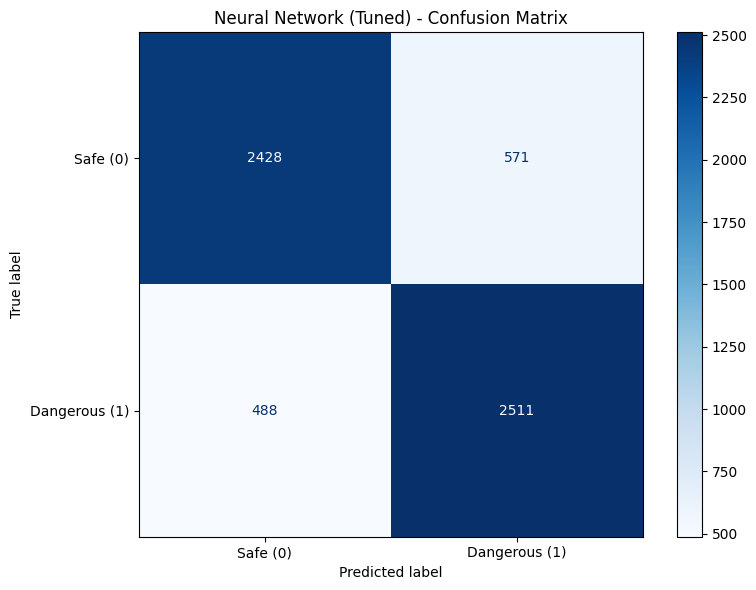

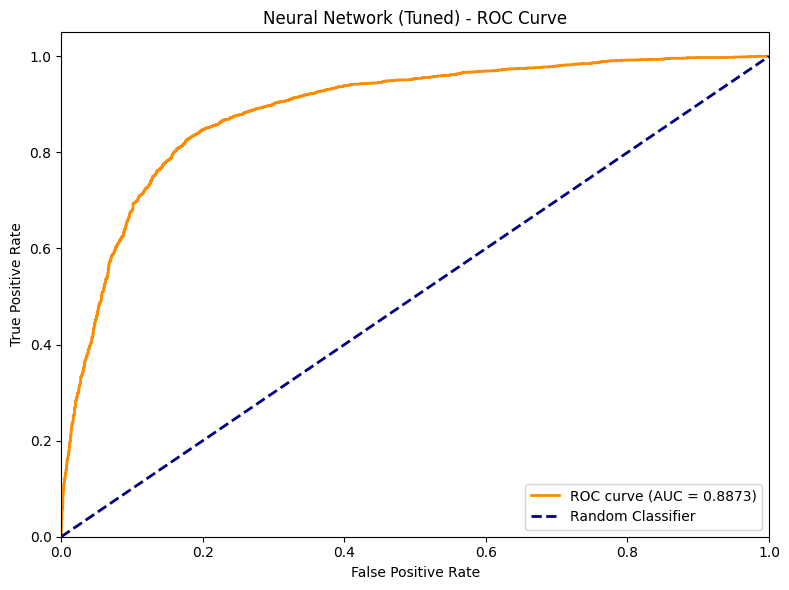

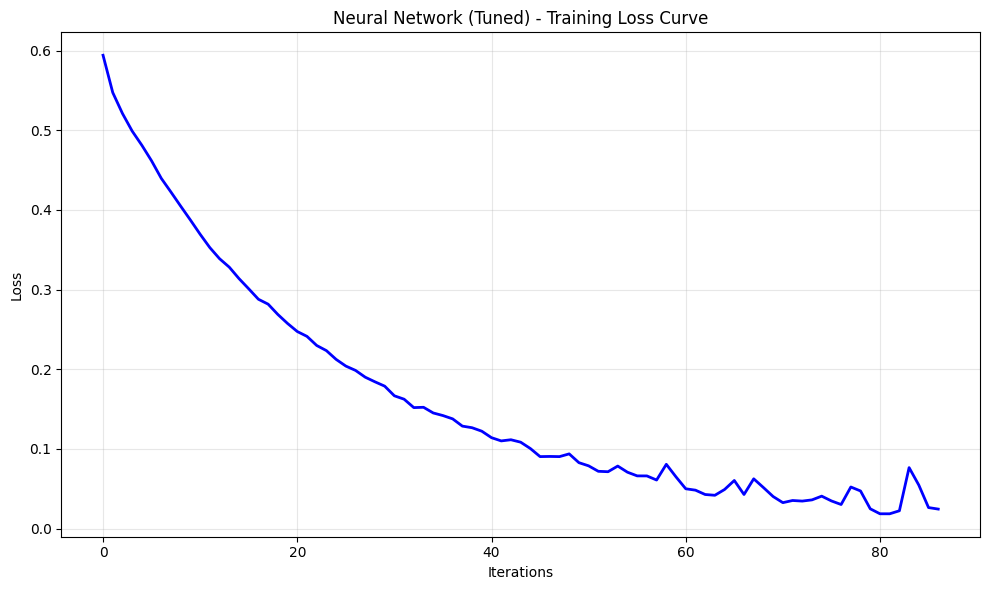

2026/01/31 17:45:02 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



✅ Tuned model logged to MLflow with ID: ced06307cbc646a88164c06c6560f591
🏃 View run NeuralNetwork_Tuned at: http://localhost:5000/#/experiments/19/runs/ced06307cbc646a88164c06c6560f591
🧪 View experiment at: http://localhost:5000/#/experiments/19


In [31]:
# Evaluate tuned model
nn_tuned = random_search.best_estimator_

with mlflow.start_run(run_name="NeuralNetwork_Tuned"):
    # Log best parameters
    mlflow.log_params({k: str(v) for k, v in random_search.best_params_.items()})
    mlflow.log_param("tuning_method", "RandomizedSearchCV")
    mlflow.log_param("n_iter", 30)
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("dataset", "balanced_smote")
    mlflow.log_param("tuning_time_minutes", round(tuning_time/60, 2))
    
    # Evaluate tuned model
    metrics_tuned, y_pred_tuned, y_proba_tuned = evaluate_model(
        nn_tuned, X_train_scaled, X_test_scaled, y_train, y_test, 
        model_name="Neural Network (Tuned)"
    )
    
    # Log metrics
    mlflow.log_metrics({
        'train_accuracy': metrics_tuned['train_accuracy'],
        'test_accuracy': metrics_tuned['test_accuracy'],
        'train_f1': metrics_tuned['train_f1'],
        'test_f1': metrics_tuned['test_f1'],
        'precision': metrics_tuned['precision'],
        'recall': metrics_tuned['recall'],
        'roc_auc': metrics_tuned['roc_auc'],
        'overfit_gap': metrics_tuned['overfit_gap'],
        'cv_best_f1': random_search.best_score_
    })
    
    # Plot and log confusion matrix
    fig_cm = plot_confusion_matrix(y_test, y_pred_tuned, "Neural Network (Tuned)")
    mlflow.log_figure(fig_cm, "confusion_matrix_tuned.png")
    plt.show()
    
    # Plot and log ROC curve
    fig_roc = plot_roc_curve(y_test, y_proba_tuned, "Neural Network (Tuned)")
    mlflow.log_figure(fig_roc, "roc_curve_tuned.png")
    plt.show()
    
    # Plot and log loss curve
    fig_loss = plot_loss_curve(nn_tuned, "Neural Network (Tuned)")
    mlflow.log_figure(fig_loss, "loss_curve_tuned.png")
    plt.show()
    
    # Log model
    signature = infer_signature(X_train_scaled, y_train)
    mlflow.sklearn.log_model(nn_tuned, "model", signature=signature)
    
    print(f"\n✅ Tuned model logged to MLflow with ID: {mlflow.active_run().info.run_id}")

In [32]:
# Compare tuned model with best base model
print("\n" + "="*70)
print("TUNING COMPARISON: Best Base Model vs Tuned Model")
print("="*70)

comparison_tuning = pd.DataFrame({
    'Model': [f'Neural Network ({best_base_label})', 'Neural Network (Tuned)'],
    'Train F1': [best_base_metrics['train_f1'], metrics_tuned['train_f1']],
    'Test F1': [best_base_metrics['test_f1'], metrics_tuned['test_f1']],
    'ROC-AUC': [best_base_metrics['roc_auc'], metrics_tuned['roc_auc']],
    'Overfit Gap': [best_base_metrics['overfit_gap'], metrics_tuned['overfit_gap']]
})

print(comparison_tuning.to_string(index=False))

# Calculate improvement
f1_improvement = metrics_tuned['test_f1'] - best_base_metrics['test_f1']
overfit_improvement = best_base_metrics['overfit_gap'] - metrics_tuned['overfit_gap']

print(f"\n📊 Improvement Summary:")
print(f"   F1 Score Change: {f1_improvement:+.4f} ({'✅ Improved' if f1_improvement > 0 else '❌ No improvement'})")
print(f"   Overfit Gap Change: {overfit_improvement:+.4f} ({'✅ Less overfitting' if overfit_improvement > 0 else '⚠️ More overfitting'})")

# Determine final best model
TUNING_IMPROVED = metrics_tuned['test_f1'] > best_base_metrics['test_f1']
if TUNING_IMPROVED:
    print(f"\n🏆 Tuned model is better! Will save tuned model.")
else:
    print(f"\n📌 Base model ({best_base_label}) is better or equal. Will save base model.")


TUNING COMPARISON: Best Base Model vs Tuned Model
                             Model  Train F1  Test F1  ROC-AUC  Overfit Gap
Neural Network (No Regularization)  1.000000 0.836282 0.893528     0.163718
            Neural Network (Tuned)  0.979455 0.825851 0.887264     0.153604

📊 Improvement Summary:
   F1 Score Change: -0.0104 (❌ No improvement)
   Overfit Gap Change: +0.0101 (✅ Less overfitting)

📌 Base model (No Regularization) is better or equal. Will save base model.


---
## 12. Save Best Model

In [33]:
import joblib
import os

# Create models directory
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Determine best model (including tuned)
models = {
    'noreg': (nn_noreg, metrics_noreg),
    'reg': (nn_reg, metrics_reg),
    'improved': (nn_improved, metrics_improved),
    'tuned': (nn_tuned, metrics_tuned)
}

best_model_name = max(models.keys(), key=lambda k: models[k][1]['test_f1'])
best_model, best_metrics = models[best_model_name]

# Save the best model
model_path = os.path.join(models_dir, 'neuralnetwork_best_model.joblib')
joblib.dump(best_model, model_path)

# Save the scaler
scaler_path = os.path.join(models_dir, 'neuralnetwork_scaler.joblib')
joblib.dump(scaler, scaler_path)

print(f"Best model saved: {model_path}")
print(f"Scaler saved: {scaler_path}")
print(f"\nBest Model: Neural Network ({best_model_name})")
print(f"Test F1 Score: {best_metrics['test_f1']:.4f}")
print(f"Overfit Gap: {best_metrics['overfit_gap']:.4f}")

Best model saved: ../models\neuralnetwork_best_model.joblib
Scaler saved: ../models\neuralnetwork_scaler.joblib

Best Model: Neural Network (noreg)
Test F1 Score: 0.8363
Overfit Gap: 0.1637


---
## Summary

This notebook trained Neural Network (MLP) models for dangerous driving detection with:

1. **No Regularization (Baseline)**: Large network (256-128-64) to establish baseline and identify overfitting
2. **With Regularization**: Smaller network (128-64-32) with L2 regularization and early stopping
3. **Improved Model**: Even smaller network (100-50) with stronger regularization and different activation

### Key Findings:
- Feature scaling (StandardScaler) is CRITICAL for neural networks
- L2 regularization (alpha parameter) controls model complexity
- Early stopping prevents over-training
- Smaller networks can generalize better on tabular data
- All experiments tracked in MLflow for comparison

### Neural Network vs. Tree-Based Models:
- Neural networks typically require more hyperparameter tuning
- Tree-based models (XGBoost, LightGBM) often perform better on tabular data
- Neural networks are more sensitive to feature scaling

### Next Steps:
- Compare with tree-based models (XGBoost, LightGBM, Random Forest)
- Consider using PyTorch/TensorFlow for more advanced architectures
- Deploy best model for production